In [1]:
import xmltodict
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels as st
import statsmodels.api as sm
from scipy import stats
from pandas import DataFrame
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score
from dateutil.parser import parse
import scipy.stats as scs
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams

#Stop warnings
import warnings
warnings.filterwarnings("ignore")

#### Read Data

In [2]:
def read_QS_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Extract datetime information
    dat["Datetime"] = pd.to_datetime(dat["Start"], format = '%d-%b-%Y %H:%M')
    dat["Date"] = dat["Datetime"].dt.date
    dat["Hour"] = dat["Datetime"].dt.hour
    #Format columns
    dat = dat[["Date", "Hour", "Steps (count)"]]
    dat.columns = ["Date", "Hour", "Steps"]
    
    return dat

def read_Pacer_data(filename):
    #Read in the data
    dat = pd.read_csv(filename)
    #Select necessary columns
    dat = dat[["date","steps"]]
    #Extract datetime data
    dat["datetime"] = pd.to_datetime(dat["date"], format = '%m/%d/%Y, %H:%M:%S %z')
    dat["Date"] = dat["datetime"].dt.date
    dat["Hour"] = dat["datetime"].dt.hour
    dat["Min"] = dat["datetime"].dt.minute
    #Aggregate over the hours
    dat = dat.groupby(["Date","Hour"])["steps"].agg("sum").reset_index()
    #Relabel columns
    dat.columns = [["Date", "Hour", "Steps"]]
    
    return dat

def read_XML_data(filename):
    #Read in XML file
    with open(filename, 'r') as xml_file:
        input_data = xmltodict.parse(xml_file.read())
    #Extract record data from XML
    record_list = input_data['HealthData']['Record']
    df = pd.DataFrame(record_list)
    #Convert dates to datetime objects and steps to numeric
    date_format = '%Y-%m-%d %H:%M:%S %z'
    df['@startDate'] = pd.to_datetime(df['@startDate'], format = date_format)
    df['@endDate'] = pd.to_datetime(df['@endDate'], format = date_format)
    df['@value'] = pd.to_numeric(df['@value'])
    #Sum up values for each hour
    dat = df.resample("H", on="@startDate").sum().reset_index()
    #Extract date and hour information, and relabel columns
    dat["Date"] = dat["@startDate"].dt.date
    dat["Hour"] = dat["@startDate"].dt.hour
    dat["Steps"] = dat["@value"]
    dat = dat[["Date","Hour","Steps"]]
    
    return dat

def read_CLEAN_data(filename):
    #Read in CSV file
    dat = pd.read_csv(filename)
    #Convert datetimes
    dat["Date"] = pd.to_datetime(dat["Date"], format = '%Y-%m-%d').dt.date
    
    return dat

#### Input Pipeline

In [3]:
def read_step_data(filename, read_type):
    read_type = read_type.lower()
    print("reading: " + filename)
    if read_type == "pacer":
        return read_Pacer_data(filename)
    elif read_type == "qsaccess" or read_type == "qs":
        return read_QS_data(filename)
    elif read_type == "xml":
        return read_XML_data(filename)
    elif read_type == "clean" or read_type == "cleaned":
        return read_CLEAN_data(filename)
    else:
        raise Exception("Not a valid file type to read! Use pacer, qs, xml or clean")

#### Adherence and Methods

In [4]:
# 10 hours of non zeroes 
def adherence_check1(df):
  df1 = df.copy()
  df1['Not Zero'] = df1['Steps'] > 0
  df1 = df1.groupby('Date').sum()
  df1 = df1['Not Zero'] > 10 
  return df1

#Greater than 500 steps
def adherence_check2(df,min):
  df1 = df.copy()
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps']> min
  return df1 

#Active in 3 time blocks 
def adherence_check3(df):
  df1 = df.copy()
  bins = [-1,2,10,14,25,np.inf]
  names = ['3','1','2', '3', '3']
  df1['3timeblock'] = pd.cut(df1['Hour'],bins, labels = names, ordered=False)
  df1 = df1.groupby(['Date','3timeblock'], as_index=False)['Steps'].sum()
  df1['Steps within timeblock'] = df1['Steps']> 0 
  df1 = df1.groupby('Date').sum()
  df1 = df1['Steps within timeblock'] ==3 
  return df1

#Combining it all into 1 dataframe
def three_method_table(x):
  valid_1= adherence_check1(x)
  valid_2= adherence_check2(x,500)
  #valid_3= adherence_check3(x)
  #result = pd.concat([valid_1,valid_2,valid_3], axis=1, join='inner')
  result = pd.concat([valid_1,valid_2], axis=1, join='inner')
  result.reset_index(level=0, inplace=True)
  #result.columns = ["Date", "10 Hours Non Zero","Steps > 500","3 Timeblock"]
  result.columns = ["Date", "10 Hours Non Zero","Steps > 500"]
  #result['All 3 True'] = result["3 Timeblock"]*result["10 Hours Non Zero"]*result["Steps > 500"]
  result['All 3 True'] = result["10 Hours Non Zero"]*result["Steps > 500"]
  result_sum = result.sum()
  return result , result_sum

def filter_by_adherence(df, measure):
    df2 = three_method_table(df)[0]
    df3 = df.merge(df2,on ='Date')
    if(measure == 1):
        mask = (df3['10 Hours Non Zero'] == True)
    elif(measure == 2):
        mask = (df3['Steps > 500'] == True)
    elif(measure == 3):
        mask = (df3['All 3 True'] == True)
    filtered_df = df3.loc[mask].drop(['10 Hours Non Zero', 'Steps > 500', 'All 3 True'], axis=1)
    #filtered_df = filtered_df.drop('index', axis=1)
    return filtered_df

# Method 1 calculates daily steps based on all the step acitivity that is available during the day
def run_method_1(df):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 2 calculates daily steps based on the 10 most active hours of the day
def run_method_2(df):
    
    df = df.sort_values(by=["Date", "Steps"], ascending=False).groupby('Date').head(10)
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

# Method 3 calculates daily steps based on a 10 hour time block during the day
def run_method_3(df, start_hour, end_hour):
    
    df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
    mask = (df['Hour'] >= start_hour) & (df['Hour'] <= end_hour)
    df = df.loc[mask]
    df.index = df["Date"]
    daily_step_count = df.drop(['Hour'], axis=1).resample('D').sum(min_count=1).dropna().reset_index()
    
    return(daily_step_count)

def calculate_daily_steps(file_name, read_type, filter_measure, start_time, end_time):
    
    df = read_step_data(filename, read_type)
    filtered_df = filter_by_adherence(df, filter_measure)
    
    dailysteps_method2 = run_method_2(filtered_df)
    dailysteps_method1 = run_method_1(filtered_df)
    dailysteps_method3 = run_method_3(filtered_df, start_time, end_time)
    
   
    return dailysteps_method1,dailysteps_method2,dailysteps_method3

In [5]:
filename = "export.xml"

filter_measure = 3
read_type = "xml"
start_time = 8
end_time = 18

ds_method1, ds_method2, ds_method3 = calculate_daily_steps(filename, read_type, filter_measure, start_time, end_time)

reading: export.xml


#### Method 1

In [6]:
ds_method1.set_index('Date',inplace=True)
ds_method1.shape

(731, 1)

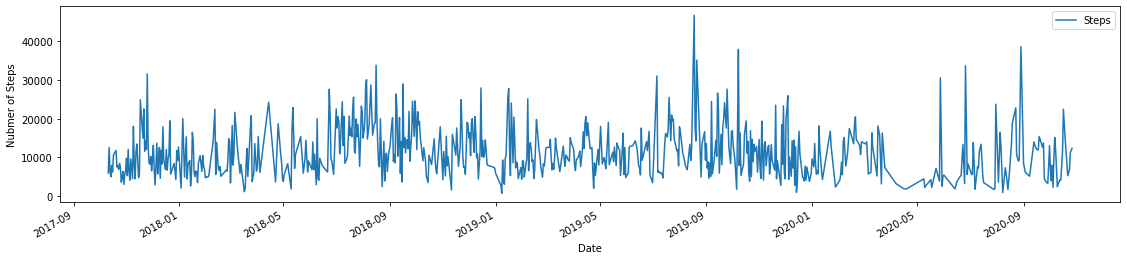

In [7]:
ds_method1.plot(figsize=(19, 4))
plt.ylabel("Nubmer of Steps")
plt.show()

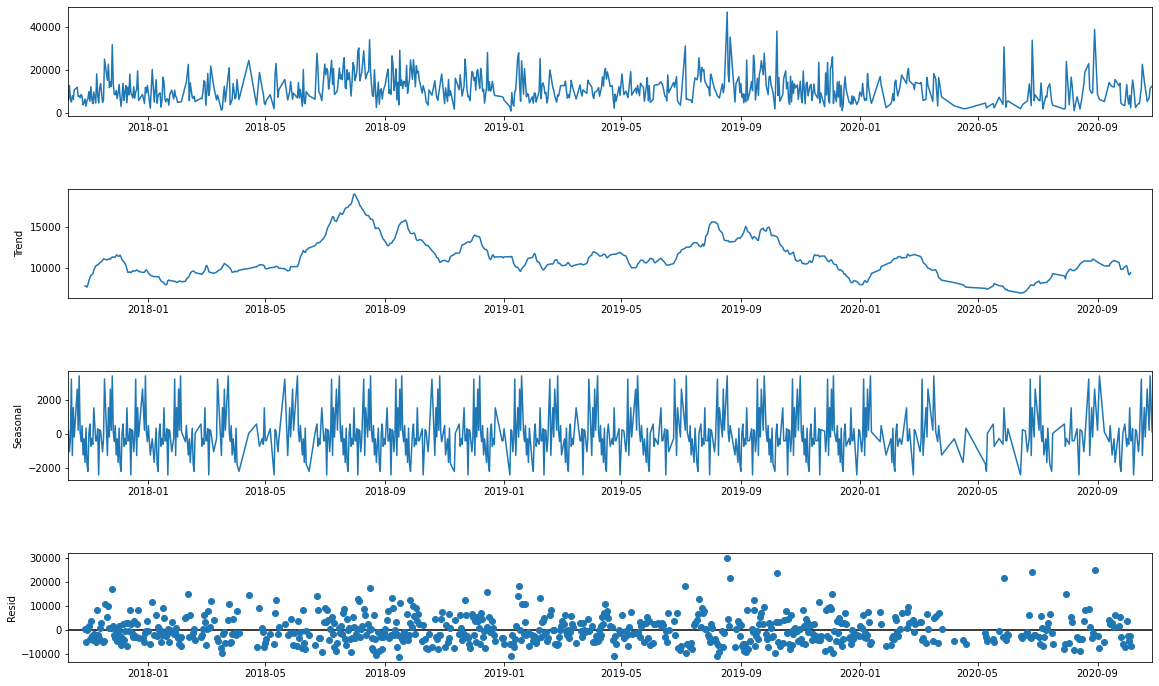

In [8]:
decomposition = sm.tsa.seasonal_decompose(ds_method1, model='additive', freq = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

The data is missing some seasonal data

#### Check for data stationary

In [9]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Number of Steps")
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Steps'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

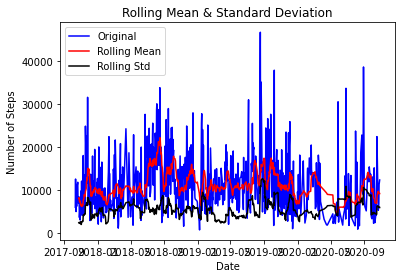

Results of Dickey Fuller Test:
ADF Test Statistic              -4.743147
p-value                          0.000070
#Lags Used                      16.000000
Number of Observations Used    714.000000
Critical Value (1%)             -3.439542
Critical Value (5%)             -2.865596
Critical Value (10%)            -2.568930
dtype: float64


In [10]:
test_stationarity(ds_method1)

For this, we will use the $\alpha$ value of 0.05 to check against the p-value of 0.000070 to decide if we will accept or reject the $H_0$. As $\alpha$ > p-value, we can conclude that the data is stationary.

#### (S)ARIMA Parameters

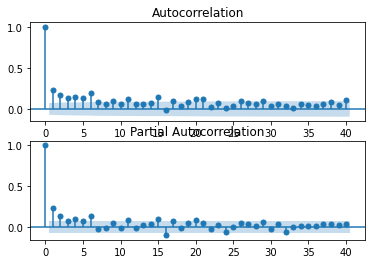

In [11]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method1, ax=ax[0], lags = 40)
fig = sm.graphics.tsa.plot_pacf(ds_method1, ax=ax[1], lags = 40)
plt.show()

In [12]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(ds_method1, start_p=0, start_q=0,
                           max_p=6, max_q=7, m=12,
                            seasonal=True,
                           d=0 , trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14891.169, BIC=14900.358, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=14854.529, BIC=14872.907, Fit time=0.918 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=14863.321, BIC=14881.698, Fit time=0.345 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14852.746, BIC=14866.529, Fit time=0.128 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=14854.440, BIC=14872.818, Fit time=0.519 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=14856.439, BIC=14879.411, Fit time=2.875 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14843.139, BIC=14861.516, Fit time=0.196 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=14844.138, BIC=14867.110, Fit time=0.377 seconds
Fit ARIMA: order=(3, 0, 

So, the best set of paramters to select is ARIMA(6,0,0)(0,0,0,12). I selected m = 12 to represent the yearly number of months each 'season' runs for.

Optimization terminated successfully.
         Current function value: 10.162264
         Iterations: 1
         Function evaluations: 86


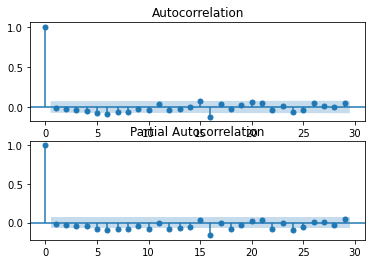

In [13]:
model = sm.tsa.statespace.SARIMAX(ds_method1, order=(6,0,0), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, ax=ax[1])
plt.show()

In [17]:
train = ds_method1.loc['2017-10-11':'2019-12-11']
test = ds_method1.loc['2020-10-27':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(6, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [18]:
mod = sm.tsa.statespace.SARIMAX(ds_method1,
                                order=(6, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  731
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -7368.727
Date:                Wed, 18 Nov 2020   AIC                          14751.454
Time:                        12:20:32   BIC                          14783.557
Sample:                             0   HQIC                         14763.843
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2459      0.033      7.365      0.000       0.180       0.311
ar.L2          0.1523      0.038      3.969      0.000       0.077       0.228
ar.L3          0.1053      0.034      3.103      0.0

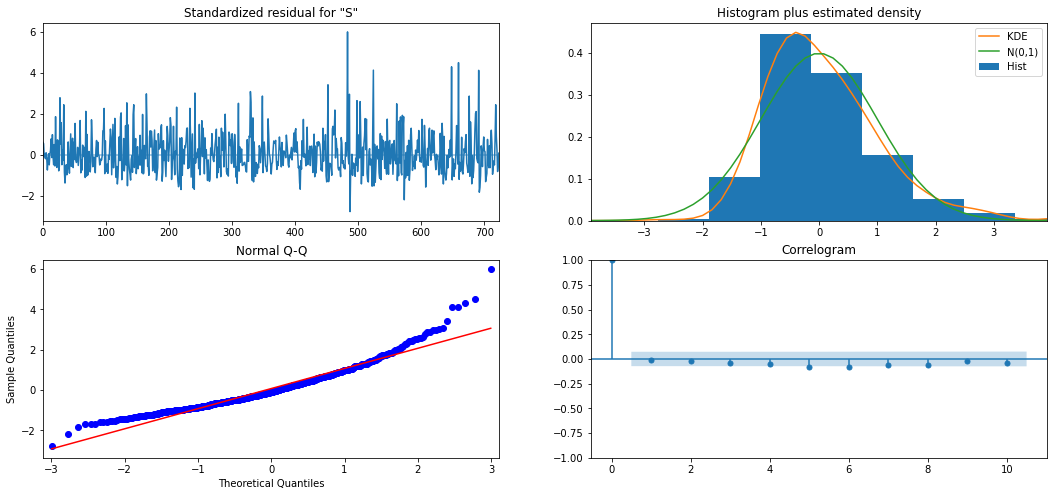

In [19]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

#### (S)ARIMA Model Validation

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error 

In [24]:
# the 20% point test data is on the specified date below
split_date = '2019-12-11'
data = ds_method1['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(6, 0, 0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [25]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae1 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse1 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse1 = math.sqrt(mse1)
print(f'Mean Squared Error: {mse1.round(4)}')
print(f'Root Mean Squared Error: {round(rmse1,4)}')
print(f'Mean Absolute Error: {mae1.round(4)}')

Mean Squared Error: 64723978.9141
Root Mean Squared Error: 8045.1214
Mean Absolute Error: 5717.4471


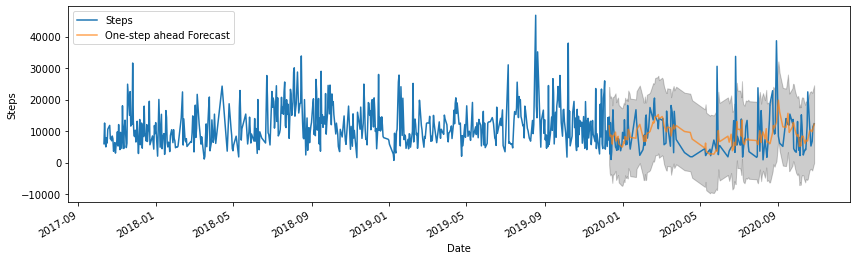

In [26]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-11'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method1['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 2

In [27]:
ds_method2.set_index('Date',inplace=True)
ds_method2.head()

,Steps
Date,
2017-10-11,5973.62973
2017-10-12,11920.50185
2017-10-13,6065.69553
2017-10-14,4963.24207
2017-10-15,7902.13639


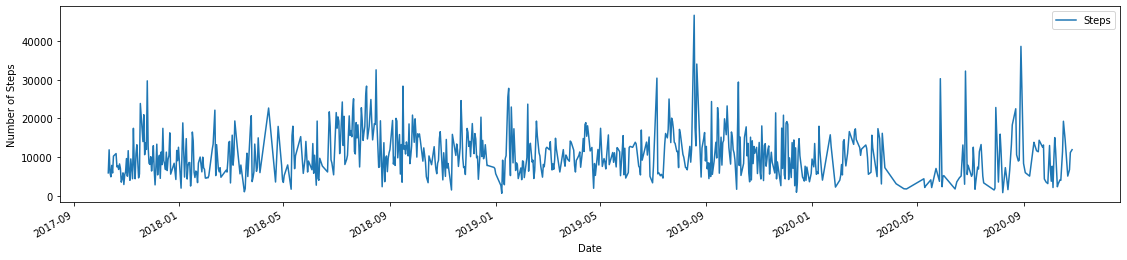

In [28]:
ds_method2.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

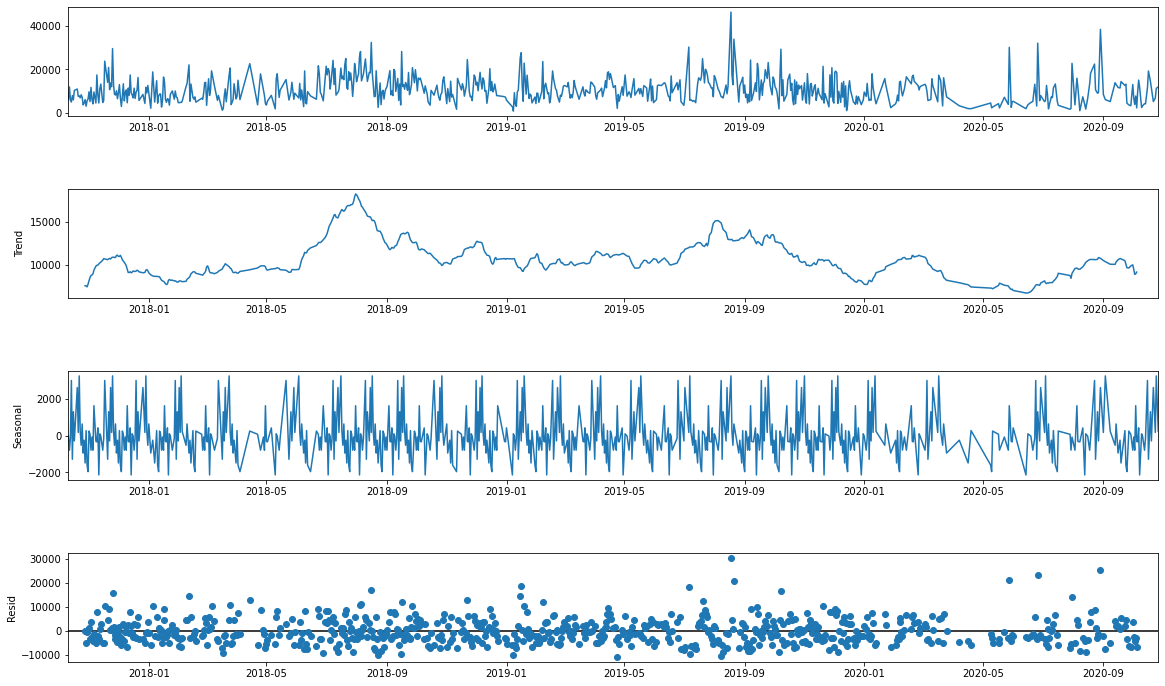

In [29]:
decomposition = sm.tsa.seasonal_decompose(ds_method2, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, missing some seasonal data

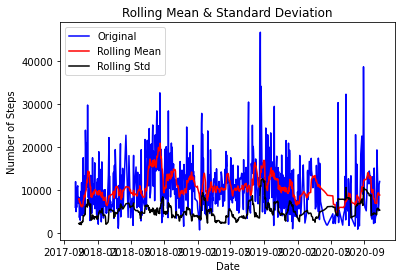

Results of Dickey Fuller Test:
ADF Test Statistic              -4.621026
p-value                          0.000118
#Lags Used                      16.000000
Number of Observations Used    714.000000
Critical Value (1%)             -3.439542
Critical Value (5%)             -2.865596
Critical Value (10%)            -2.568930
dtype: float64


In [31]:
test_stationarity(ds_method2)

Data appears to be stationary

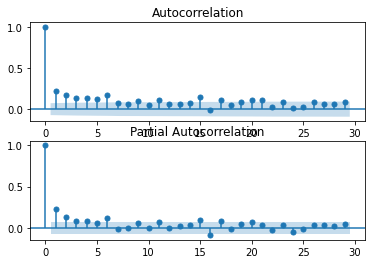

In [32]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method2, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method2,ax=ax[1])
plt.show()

In [33]:
stepwise_model = auto_arima(ds_method2, start_p=0, start_q=0,
                           max_p=6, max_q=7, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=14767.092, BIC=14785.470, Fit time=0.761 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14766.294, BIC=14775.483, Fit time=0.035 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=14732.708, BIC=14751.085, Fit time=0.415 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=14740.398, BIC=14758.776, Fit time=0.285 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14731.254, BIC=14745.037, Fit time=0.091 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=14732.500, BIC=14750.878, Fit time=0.314 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=14734.492, BIC=14757.464, Fit time=1.455 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14721.510, BIC=14739.887, Fit time=0.154 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=14722.296, BIC=14745.268, Fit time=0.309 seconds
Fit ARIMA:

Best SARIMA is  order=(6,0,0) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 10.083838
         Iterations: 1
         Function evaluations: 86


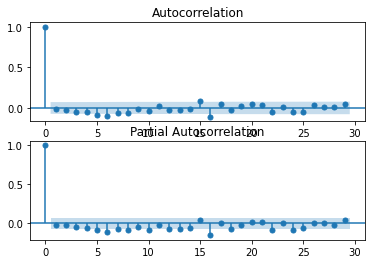

In [34]:
model = sm.tsa.statespace.SARIMAX(ds_method2, order=(6,0,0), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res,  ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res,  ax=ax[1])
plt.show()

In [40]:
train = ds_method2.loc['2017-10-11':'2019-12-11']
test = ds_method2.loc['2020-10-27':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(6, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [41]:
mod = sm.tsa.statespace.SARIMAX(ds_method2,
                                order=(7,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  731
Model:               SARIMAX(7, 0, 0)   Log Likelihood               -7301.074
Date:                Wed, 18 Nov 2020   AIC                          14618.147
Time:                        12:25:52   BIC                          14654.826
Sample:                             0   HQIC                         14632.304
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2344      0.033      7.044      0.000       0.169       0.300
ar.L2          0.1528      0.039      3.964      0.000       0.077       0.228
ar.L3          0.1127      0.032      3.482      0.0

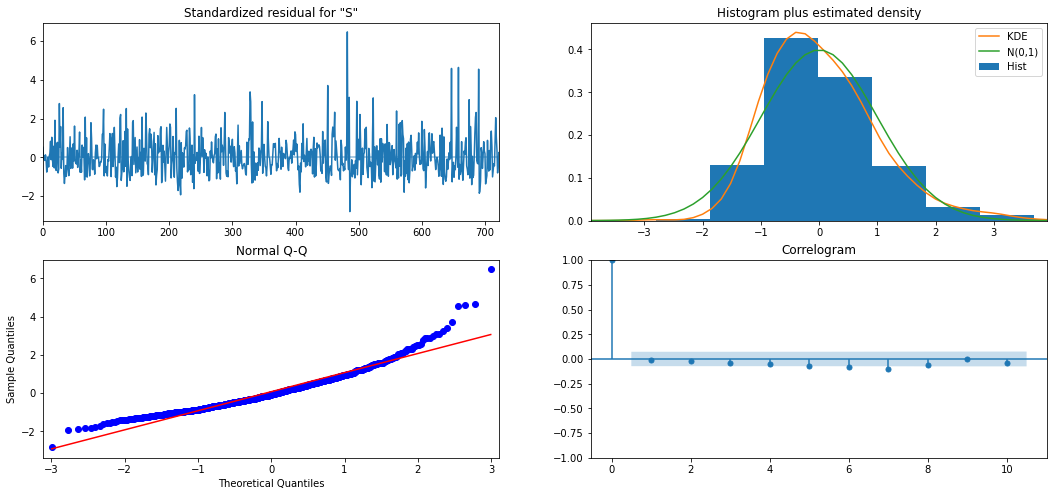

In [42]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [44]:
# the 20% point test data is on the specified date below
split_date = '2019-12-11'
data = ds_method2['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(6,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [45]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae2 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse2 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse2 = math.sqrt(mse2)
print(f'Mean Squared Error: {mse2.round(4)}')
print(f'Root Mean Squared Error: {round(rmse2,4)}')
print(f'Mean Absolute Error: {mae2.round(4)}')

Mean Squared Error: 58961093.8409
Root Mean Squared Error: 7678.6128
Mean Absolute Error: 5448.8621


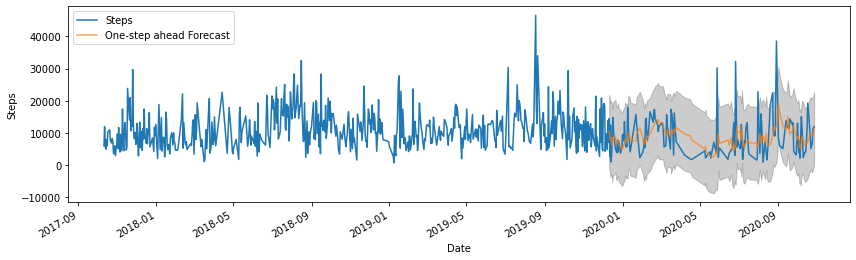

In [46]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-11'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method2['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

#### Method 3

In [47]:
ds_method3.set_index('Date',inplace=True)
ds_method3.head()

,Steps
Date,
2017-10-11,4846.92129
2017-10-12,10834.66088
2017-10-13,5690.49222
2017-10-14,4449.92479
2017-10-15,7080.65346


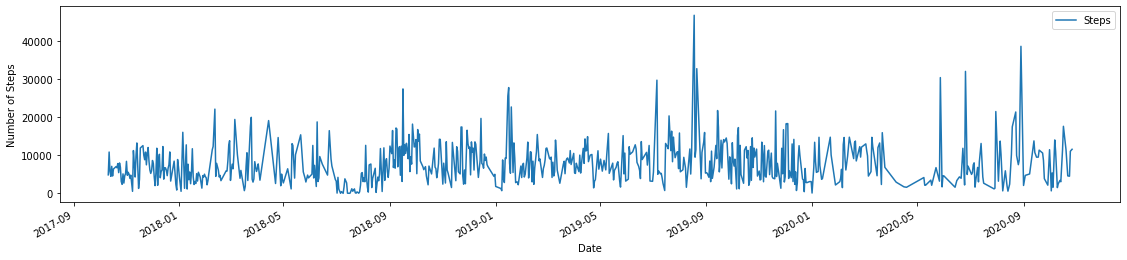

In [48]:
ds_method3.plot(figsize=(19, 4))
plt.ylabel("Number of Steps")
plt.show()

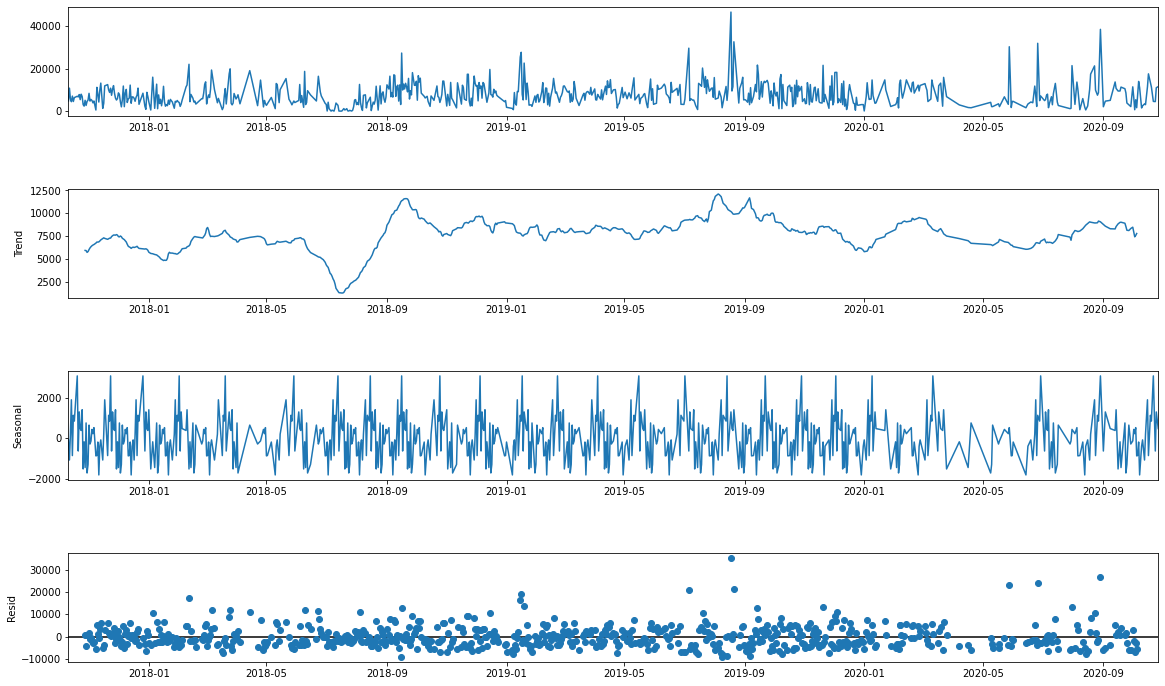

In [49]:
decomposition = sm.tsa.seasonal_decompose(ds_method3, model='additive', period = 30)
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

Again, seasonal data is missing

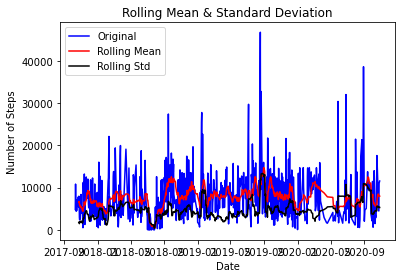

Results of Dickey Fuller Test:
ADF Test Statistic            -8.075588e+00
p-value                        1.508609e-12
#Lags Used                     5.000000e+00
Number of Observations Used    7.250000e+02
Critical Value (1%)           -3.439402e+00
Critical Value (5%)           -2.865535e+00
Critical Value (10%)          -2.568897e+00
dtype: float64


In [50]:
test_stationarity(ds_method3)

P-value is significant, our data is stationary

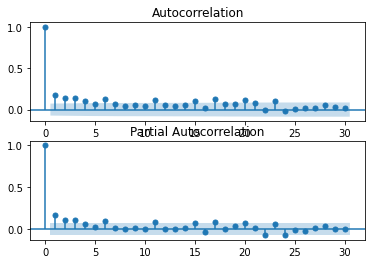

In [51]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(ds_method3, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ds_method3, lags=30, ax=ax[1])
plt.show()

In [52]:
stepwise_model = auto_arima(ds_method3, start_p=0, start_q=0,
                           max_p=6, max_q=8, m=12,
                            seasonal=True,
                           d=0,  trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=14630.446, BIC=14648.824, Fit time=0.618 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14628.763, BIC=14637.951, Fit time=0.029 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=14610.667, BIC=14629.045, Fit time=0.459 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=14614.419, BIC=14632.796, Fit time=0.277 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14609.174, BIC=14622.957, Fit time=0.080 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=14610.437, BIC=14628.814, Fit time=0.437 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=14612.434, BIC=14635.406, Fit time=1.344 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=14601.587, BIC=14619.965, Fit time=0.128 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 12); AIC=14601.688, BIC=14624.660, Fit time=0.272 seconds
Fit ARIMA:

Best ARIMA order=(4, 0, 0) seasonal_order=(0, 0, 0, 12)

Optimization terminated successfully.
         Current function value: 10.035374
         Iterations: 1
         Function evaluations: 61


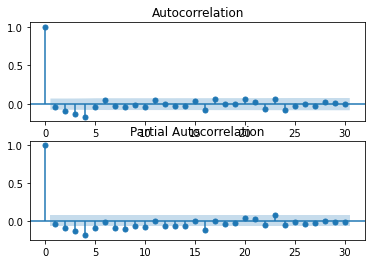

In [53]:
model = sm.tsa.statespace.SARIMAX(ds_method3, order=(4,0,0), seasonal_order = (0,0,0,12)).fit(max_iter=50, method='powell')
res = model.resid
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(res, lags=30, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=30, ax=ax[1])
plt.show()

In [54]:
train = ds_method3.loc['2017-10-11':'2019-12-11']
test = ds_method3.loc['2020-10-27':]
stepwise_model.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(4, 0, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [55]:
mod = sm.tsa.statespace.SARIMAX(ds_method3,
                                order=(4,0,0),
                                seasonal_order=(0, 0, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  Steps   No. Observations:                  731
Model:               SARIMAX(4, 0, 0)   Log Likelihood               -7296.114
Date:                Wed, 18 Nov 2020   AIC                          14602.227
Time:                        12:28:22   BIC                          14625.172
Sample:                             0   HQIC                         14611.081
                                - 731                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2668      0.029      9.322      0.000       0.211       0.323
ar.L2          0.2215      0.036      6.222      0.000       0.152       0.291
ar.L3          0.2279      0.030      7.645      0.0

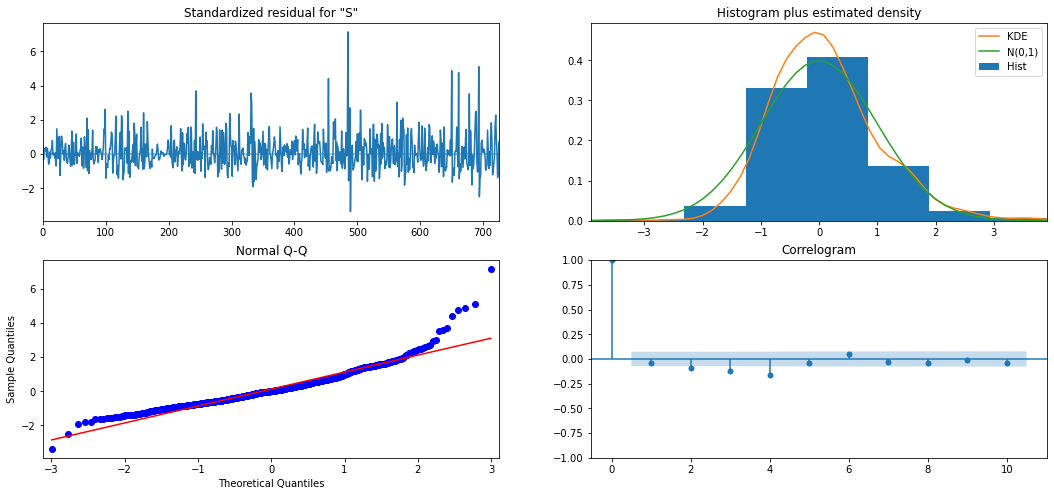

In [56]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [57]:
# the 20% point test data is on the specified date below
split_date = '2019-12-11'
data = ds_method3['Steps']
train, test = data[:split_date], data[split_date:]
test_len = len(test)
model = sm.tsa.statespace.SARIMAX(train,
                                order=(4,0,0),
                                seasonal_order=(0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
model_fit = model.fit(disp=-1)
prediction = model_fit.forecast(test_len)

In [58]:
pred_df = pd.DataFrame(np.array(prediction), index= test.index)
mae3 = mean_absolute_error(test.dropna(), pred_df.dropna())
mse3 = mean_squared_error(test.dropna(), pred_df.dropna())
rmse3 = math.sqrt(mse3)
print(f'Mean Squared Error: {mse3.round(4)}')
print(f'Root Mean Squared Error: {round(rmse3,4)}')
print(f'Mean Absolute Error: {mae3.round(4)}')

Mean Squared Error: 78050155.658
Root Mean Squared Error: 8834.5999
Mean Absolute Error: 6531.5218


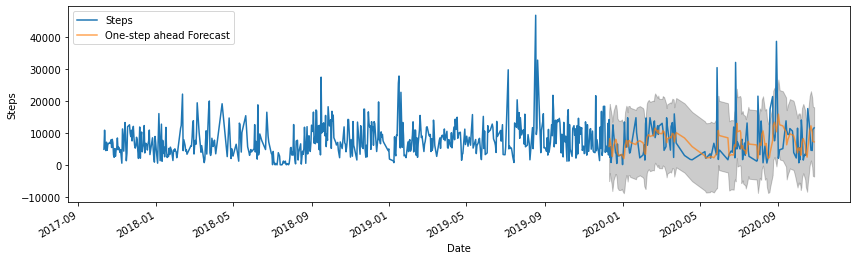

In [59]:
pred = results.get_prediction(start=pd.to_datetime('2019-12-11'), dynamic=False)
pred_ci = pred.conf_int()
#Potentially change the start date so its more zoomed in? 
ax = ds_method3['2017':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Steps')
plt.legend()
plt.show()

In [60]:
models = pd.DataFrame({
    'Method': ['Method 1', 'Method 2', 'Method 3'],
    'MSE': [round(mse1, 4), round(mse2, 4), round(mse3,4)],
    'RMSE': [round(rmse1,4 ), round(rmse2, 4), round(rmse3,4)],
    'MAE': [round(mae1, 4), round(mae2, 4), round(mae3,4)]})
models

,Method,MSE,RMSE,MAE
0,Method 1,6.472398e+07,8045.1214,5717.4471
1,Method 2,5.896109e+07,7678.6128,5448.8621
2,Method 3,7.805016e+07,8834.5999,6531.5218


Based on the above predictions, we can observe that **Method 1** and **Method 2** have a very similar prediction with **Method 3** performing the worst. However, the **RMSE** value of **Model 2** is lower, therefore, we can conclude that the **Method 2** performs the best here.